In [27]:
import os
import subprocess
import time
import pickle

import numpy as np

from matplotlib import pyplot as plt

import random
%matplotlib inline

In [28]:
import cv2

In [29]:
class Env:
    def __init__(self):
        self.restart_btn_img = cv2.imread('./restart_button.png', cv2.IMREAD_GRAYSCALE)
        self.action_space = range(20)
        self.dist_space = np.linspace(300, 1000, len(self.action_space))
    
    def __jump(self, distance):
        subprocess.call(".\\adb\\adb shell input swipe 500 500 500 500 %d" % distance)
        time.sleep(distance / 1000 + 2)
        
        
    def __capture_img(self, filename):
        subprocess.call('.\\adb\\adb shell /system/bin/screencap -p /sdcard/screenshot.png')
        time.sleep(0.1)
        subprocess.call('.\\adb\\adb pull /sdcard/screenshot.png %s' % filename)
        time.sleep(0.1)

        
    def __find_restart_btn(self, screen_shot_im):
        result = cv2.matchTemplate(screen_shot_im,
                                   self.restart_btn_img,
                                   cv2.TM_CCOEFF_NORMED)
        if result.max() > 0.8:
            y,x = np.unravel_index(result.argmax(),result.shape)
            y += self.restart_btn_img.shape[0] // 2
            x += self.restart_btn_img.shape[1] // 2
            return x, y
        else:
            return -1, -1
        
    def __to_state(self, screen_shot_im):
        return np.expand_dims(cv2.resize(screen_shot_im, (120, 200)) / 255.0,-1)
    
    
    def dist(self, action):
        d = action * 400 + 700
        if d < 300:
            d = 300
        elif d > 1100:
            d = 1100
            
        return d
        
        
    def reset(self):
        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            # Kill self
            self.__jump(1500)
            self.__capture_img('./tmp/screenshot.png')
            im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
            btn_x, btn_y = self.__find_restart_btn(im)
            
            assert btn_x != -1
                
        subprocess.call('.\\adb\\adb shell input tap %d %d' % (btn_x, btn_y))
        time.sleep(0.5)

        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)

        assert btn_x == -1
        
        return self.__to_state(im)
        
        
    def step(self, action):
        '''
        action: touch time(milliseconds)
        return: 
        '''
        time.sleep(0.5)
        
        dist = self.dist(action)
        self.__jump(dist)
        
        self.__capture_img('./tmp/screenshot.png')
        
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            state = self.__to_state(im)
            reward = 1
            done = False
            return state, reward, done
        else:
            state = None
            reward = -1
            done = True
            return state, reward, done
        

In [30]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3369393314891093666
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 85236121
locality {
  bus_id: 1
}
incarnation: 17342439395837549925
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:23:00.0, compute capability: 6.1"
]


In [31]:
from keras.layers import *
from keras.models import Model,load_model,Sequential
from keras.callbacks import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.applications.resnet50 import identity_block, conv_block

In [32]:
import tensorflow as tf

In [33]:
class ActorNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        K.set_session(sess)

        #Now create the model
        self.model , self.weights, self.state = self.create_actor_network()   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network() 
        self.action_gradient = tf.placeholder(tf.float32,[None, 1])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)
        self.sess.run(tf.initialize_all_variables())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(16, (8, 8), strides=(4,4), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)

        outputs = Dense(1, activation='tanh')(x)
        model = Model(inputs, outputs)
        model.compile(loss='mean_squared_error', optimizer=Nadam(lr=self.LEARNING_RATE))

        return model, model.trainable_weights, inputs

In [34]:
class CriticNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        
        K.set_session(sess)

        #Now create the model
        self.model, self.state, self.action = self.create_critic_network()  
        self.target_model, self.target_state, self.target_action = self.create_critic_network()  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.initialize_all_variables())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        state_inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(state_inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(16, (8, 8), strides=(4,4), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x_s = Dense(256, activation='relu')(x)
        
        action_inputs = Input(shape=(1,))
        x_a = Dense(256, activation='relu')(action_inputs)
        
        x = Add()([x_s,x_a])
        x = Dense(256, activation='linear')(x)
        outputs = Dense(1, activation='linear')(x)
        
        model = Model([state_inputs, action_inputs], outputs)
        model.compile(loss='mean_squared_error', optimizer=Nadam(lr=self.LEARNING_RATE))
 
        return model, state_inputs, action_inputs 

In [41]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.memory = []
        
        self.GAMMA = 0.99
        self.TAU = 0.001     #Target Network HyperParameters
        self.LRA = 0.0001    #Learning rate for Actor
        self.LRC = 0.001     #Lerning rate for Critic

        self.episode_count = 2000
        self.max_steps = 100000
        self.reward = 0
        self.done = False
        self.step = 0
        self.epsilon = 1
        self.epsilon_decay = .97
        self.epsilon_min = 0
        self.indicator = 0

        #Tensorflow GPU optimization
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        K.set_session(self.sess)
        
        self.BATCH_SIZE = 32
        
        self.mem_len = 200

        self.actor = ActorNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRA)
        self.critic = CriticNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRC)
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def act(self, state):
        noise = random.gauss(mu=0,sigma=0.5) * self.epsilon
        
        act = self.actor.model.predict_on_batch(np.expand_dims(state,0))[0][0]
        
        print('act:',act,'noise:',noise,'sum:',act+noise)
        
        return act + noise
    
    
    def replay(self):
        mem = self.memory[-self.mem_len:]
        
        n_batch = min(self.BATCH_SIZE, len(mem))
        batches = np.random.choice(len(mem), n_batch)
        
        states = []
        actions = []
        rewards = []
        new_states = []
        dones = []
        
        for i,mem_idx in enumerate(batches):
            state, action, reward, next_state, done = mem[mem_idx]
            
            if done:
                next_state = np.zeros_like(state)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            new_states.append(next_state)
            dones.append(done)
        
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        new_states = np.array(new_states)

        target_q_values = self.critic.target_model.predict_on_batch(
            [new_states, self.actor.target_model.predict_on_batch(new_states)])
        
        y_t = []
        
        for k,d in enumerate(dones):
            if d:
                y_t.append(rewards[k])
            else:
                y_t.append(rewards[k] + self.GAMMA*target_q_values[k])
                
        y_t = np.array(y_t)
        
        loss = self.critic.model.train_on_batch([states,actions], y_t) 
        a_for_grad = self.actor.model.predict_on_batch(states)
        grads = self.critic.gradients(states, a_for_grad)
        self.actor.train(states, grads)
        self.actor.target_train()
        self.critic.target_train()
        
        return loss

In [36]:
episodes = 1000

# 为agent初始化gym环境参数
env = Env()

(array([  64.,   57.,   92.,  141.,  151.,  151.,  140.,   90.,   60.,   54.]),
 array([  300.,   380.,   460.,   540.,   620.,   700.,   780.,   860.,
          940.,  1020.,  1100.]),
 <a list of 10 Patch objects>)

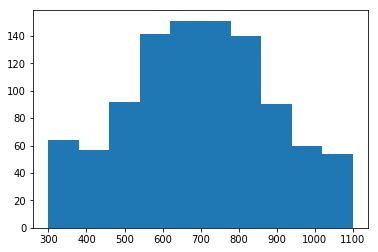

In [26]:
plt.hist([env.dist(i) for i in list(np.random.randn(1000) * 0.5)])

In [42]:
agent = Agent(env)
agent.actor.model.summary()
agent.critic.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 200, 120, 1)       0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 120, 120, 1)       0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 16)        1040      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 32)          8224      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 8, 32)          0         
__________

In [43]:
scores = []

In [55]:
# 游戏的主循环
for e in range(episodes):

    # 在每次游戏开始时复位状态参数
    state = env.reset()

    # time_t 代表游戏的每一帧
    # time_t 越大，分数越高
    
    loss = 0
    for time_t in range(10000):
        
        # turn this on if you want to render
        # env.render()

        # 选择行为
        action = agent.act(state)

        # 在环境中施加行为推动游戏进行
        next_state, reward, done = env.step(action)
        
        print('jump dist:', env.dist(action))

        # 记忆先前的状态，行为，回报与下一个状态
        agent.remember(state, action, reward, next_state, done)

        # 使下一个状态成为下一帧的新状态
        state = copy.deepcopy(next_state)
        
        loss += agent.replay()

        # 如果游戏结束done被置为ture
        # 除非agent没有完成目标
        if done:
            # 打印分数并且跳出游戏循环
            print("episode: {}/{}, score: {}"
                  .format(e, episodes, time_t))
            scores.append(time_t)
            break
    
    loss /= (time_t+1)
    
    print('mem:', len(agent.memory), 'epsilon:', agent.epsilon, 'loss:', loss)
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

act: 0.0276923 noise: -0.28258926838721726 sum: -0.254896920622
jump dist: 598.041231751
act: 0.0277929 noise: 0.01608581336961408 sum: 0.0438786918186
jump dist: 717.551476727
act: 0.031119 noise: 0.2903736666202605 sum: 0.321492687276
jump dist: 828.59707491
episode: 0/1000, score: 2
mem: 830 epsilon: 0.5 loss: 0.0128104204002
act: 0.0321573 noise: 0.09242110601261481 sum: 0.124578411641
jump dist: 749.831364656
act: 0.0342657 noise: -0.385042527205072 sum: -0.350776852554
jump dist: 559.689258978
act: 0.0300814 noise: 0.1956800967291692 sum: 0.225761448948
jump dist: 790.304579579
episode: 1/1000, score: 2
mem: 833 epsilon: 0.485 loss: 0.116220846772
act: 0.0322964 noise: 0.37890412542524105 sum: 0.411200514767
jump dist: 864.480205907
act: 0.0305216 noise: -0.21943334622414207 sum: -0.188911754099
jump dist: 624.43529836
act: 0.035694 noise: 0.11148277896743133 sum: 0.147176811875
jump dist: 758.87072475
act: 0.0325399 noise: 0.07004198953537619 sum: 0.102581875027
jump dist: 741.0

jump dist: 687.020290685
act: 0.231106 noise: -0.12372777840045704 sum: 0.107378279363
jump dist: 742.951311745
episode: 21/1000, score: 2
mem: 903 epsilon: 0.26374025631947234 loss: 0.0417368498941
act: 0.218152 noise: -0.003073031470116399 sum: 0.215078850821
jump dist: 786.031540328
act: 0.204868 noise: 0.0690120788551704 sum: 0.273879888866
jump dist: 809.551955546
act: 0.214558 noise: -0.06136504399082974 sum: 0.153192648418
jump dist: 761.277059367
act: 0.202952 noise: -0.08980499713145851 sum: 0.113147447422
jump dist: 745.258978969
episode: 22/1000, score: 3
mem: 907 epsilon: 0.25582804862988817 loss: 0.0534759550355
act: 0.194484 noise: 0.10075760654398913 sum: 0.295242049016
jump dist: 818.096819607
act: 0.189975 noise: 0.12886181924728204 sum: 0.318836738209
jump dist: 827.534695284
act: 0.182505 noise: -0.09889580320154069 sum: 0.0836089252349
jump dist: 733.443570094
act: 0.177701 noise: -0.28326982156217145 sum: -0.105568586745
jump dist: 657.772565302
act: 0.180703 noise

KeyboardInterrupt: 

In [52]:
agent.epsilon = 0.5
agent.epsilon_min = 0.15

In [54]:
pickle.dump(agent.memory,open('./tmp/ddpg_mem.m','wb'))

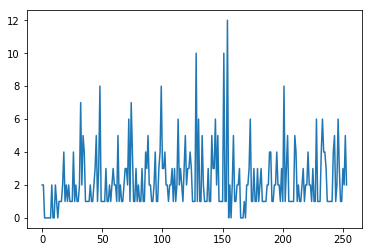

In [53]:
plt.plot(range(len(scores)),scores)

In [ ]:
f, axes = plt.subplots(4,10,figsize=(20,8))

for i in range(4):
    for j in range(10):
        if i % 2 == 0:
            state = random.choice(agent.memory)[0]
            pic = state[50:170,:,0]
            axes[i][j].imshow(pic, cmap='gray')
        
            axes[i+1][j].bar(agent.env.action_space,agent.model.predict(np.expand_dims(state,0))[0])

In [47]:
%debug

> <ipython-input-11-31b434801c34>(8)__jump()
      6 
      7     def __jump(self, distance):
----> 8         subprocess.call(".\\adb\\adb shell input swipe 500 500 500 500 %d" % distance)
      9         time.sleep(distance / 1000 + 2)
     10 

ipdb> action
416.63022541769755
ipdb> dist
*** NameError: name 'dist' is not defined
ipdb> distance
ipdb> up
> <ipython-input-11-31b434801c34>(75)step()
     73 
     74         dist = self.dist(action)
---> 75         self.__jump(dist)
     76 
     77         self.__capture_img('./tmp/screenshot.png')

ipdb> action
416.63022541769755
ipdb> self.dist
<bound method Env.dist of <__main__.Env object at 0x0000018C4FEBAD68>>
ipdb> self.dist(action)
ipdb> dist
ipdb> q


In [70]:
agent.epsilon = 0.01

<Container object of 20 artists>

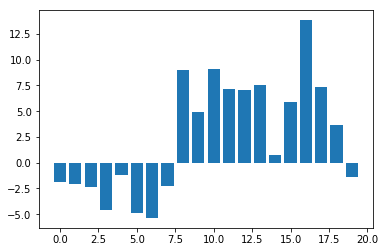

In [117]:
plt.bar(agent.env.action_space,agent.model.predict(np.expand_dims(agent.memory[][0],0))[0])

In [91]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(*args, **kwargs)
    Make a bar plot.
    
    Call signatures::
    
       bar(x, height, *, align='center', **kwargs)
       bar(x, height, width, *, align='center', **kwargs)
       bar(x, height, width, bottom, *, align='center', **kwargs)
    
    Make a bar plot with rectangles bounded by
    
    .. math::
    
       (x - width/2, x + width/2, bottom, bottom + height)
    
    (left, right, bottom and top edges) by default.  *x*,
    *height*, *width*, and *bottom* can be either scalars or
    sequences.
    
    The *align* and *orientation* kwargs control the interpretation of *x*
    and *bottom*
    
    The *align* keyword-only argument controls if *x* is interpreted
    as the center or the left edge of the rectangle.
    
    Parameters
    ----------
    x : sequence of scalars
        the x coordinates of the bars.
    
        *align* controls if *x* is the bar center (default) or
        left edge.
    
    heig

In [138]:
agent.model.save_weights('./tmp/weights.w')
pickle.dump(agent.memory, open('./tmp/memory.m','wb'))

In [68]:
min_loss = 1e10
min_pos = 0

for i in range(1000):
    loss = 0
    for i in range(50):
        l = agent.replay(32)
        loss += l
    print(loss / 50)
    
    if loss < min_loss:
        min_pos = i
        min_loss = loss
    
    if i - min_pos > 100:
        break

i

128.82689827
94.7225925446
37.4278962708
31.1282489967
15.9667807198
16.0796065235
14.0383515739
12.0921261883
11.2964262009
8.64634869099
7.35213395119
7.32252527714
6.3635424757
4.71984107256
4.57263987064
3.77086829185
4.77240906715
3.48491025209
9.52575344563
5.55766092539
4.55353834867
3.18393145323
2.79013663769
2.49263638139
3.06989862561
4.35556167364
2.88895393372
2.96023203969
3.11350908041
4.47541817427
3.99412070513


KeyboardInterrupt: 

In [58]:
i, min_pos

(228, 227)

In [178]:
agent.epsilon

0.20554993075174754